# Etapa 1: Buscador de Imágenes por Similitud

In [138]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"juliasumiacher","key":"096b925e78e54d147345f3b468a6e174"}'}

In [139]:
import os
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Descarga el dataset
!kaggle datasets download -d gpiosenka/70-dog-breedsimage-data-set

# Descomprime el archivo zip
!unzip 70-dog-breedsimage-data-set.zip -d /content/dataset

Dataset URL: https://www.kaggle.com/datasets/gpiosenka/70-dog-breedsimage-data-set
License(s): CC0-1.0
70-dog-breedsimage-data-set.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  70-dog-breedsimage-data-set.zip
replace /content/dataset/dogs.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Instalaciones necesarias

In [140]:
!pip install gradio faiss-cpu tqdm

### Imports

In [141]:
import os
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as T
import faiss
import gradio as gr
import shutil
import random
from collections import Counter
from torchvision import models
from PIL import Image
from tqdm import tqdm

### Paths y configuración

In [142]:
DATASET_DIR = '/content/dataset/train'
EMBEDDINGS_PATH = '/content/dog_embeddings.npy'
LABELS_PATH = '/content/dog_labels.npy'
IMG_PATHS_PATH = '/content/dog_img_paths.npy'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1. Creación de la Base de Datos Vectorial

### Transformación de las imágenes

In [143]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Modelo preentrenado (ResNet50, sin última capa)

In [144]:
model = models.resnet50(weights='IMAGENET1K_V2')
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model.to(DEVICE)
model.eval()

def get_embedding(img):
    img = transform(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        emb = model(img).squeeze().cpu().numpy()
    return emb / np.linalg.norm(emb)  # Normaliza el vector

### Indexar todas las imágenes del dataset

In [145]:
if not (os.path.exists(EMBEDDINGS_PATH) and os.path.exists(LABELS_PATH)):
    embeddings = []
    labels = []
    img_paths = []
    for breed in tqdm(os.listdir(DATASET_DIR), desc="Razas"):
        folder = os.path.join(DATASET_DIR, breed)
        if not os.path.isdir(folder): continue
        for fname in os.listdir(folder):
            if not fname.lower().endswith(('jpg', 'jpeg', 'png')): continue
            fpath = os.path.join(folder, fname)
            try:
                img = Image.open(fpath).convert('RGB')
                emb = get_embedding(img)
                embeddings.append(emb)
                labels.append(breed)
                img_paths.append(fpath)
            except Exception as e:
                print(f"Error con {fpath}: {e}")
    embeddings = np.stack(embeddings)
    np.save(EMBEDDINGS_PATH, embeddings)
    np.save(LABELS_PATH, np.array(labels))
    np.save(IMG_PATHS_PATH, np.array(img_paths))
else:
    embeddings = np.load(EMBEDDINGS_PATH)
    labels = np.load(LABELS_PATH)
    img_paths = np.load(IMG_PATHS_PATH)

### Crear índice FAISS para búsqueda rápida

In [146]:
index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings)

### Función de búsqueda + voto mayoritario

In [147]:
def search_similar(query_img, k=10):
    img = Image.fromarray(query_img).convert('RGB')
    query_emb = get_embedding(img).reshape(1, -1)
    D, I = index.search(query_emb, k)
    sim_imgs = [img_paths[i] for i in I[0]]
    sim_labels = [labels[i] for i in I[0]]
    # Voto mayoritario
    pred_raza = Counter(sim_labels).most_common(1)[0][0]
    return sim_imgs, sim_labels, pred_raza

## 2. Desarrollo de la Aplicación en Gradio


### Interfaz Gradio

In [148]:
def gradio_fn(img):
    sim_imgs, sim_labels, pred_raza = search_similar(img)
    captions = [f"{os.path.basename(x)}\n({l})" for x, l in zip(sim_imgs, sim_labels)]
    gallery = [[x, c] for x, c in zip(sim_imgs, captions)]
    return pred_raza, gallery

with gr.Blocks() as demo:
    gr.Markdown("# Buscador de Razas de Perros por Similitud")
    inp = gr.Image(type="numpy", label="Subí una imagen de un perro")
    raza = gr.Textbox(label="Raza Predicha", interactive=False)
    gal = gr.Gallery(label="Top 10 similares (nombre archivo y raza)", columns=5, height="auto")
    inp.upload(gradio_fn, inp, [raza, gal])
    gr.Markdown("Subí una foto y el sistema buscará las más similares en el dataset usando ResNet50.")

# Para lanzar la interfaz:
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0681978f10bba857ee.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## 3. Clasificación Basada en Similitud + Métrica de Evaluación

### Evaluación NDCG@10

In [149]:
def ndcg_at_k(predicted_labels, true_label, k=10):
    """
    Calcula NDCG@k para una búsqueda (solo 1 relevancia máxima: misma raza)
    """
    relevances = [1 if l == true_label else 0 for l in predicted_labels[:k]]
    dcg = sum([rel / np.log2(idx + 2) for idx, rel in enumerate(relevances)])
    ideal = [1] + [0] * (k - 1)
    idcg = sum([rel / np.log2(idx + 2) for idx, rel in enumerate(ideal)])
    return dcg / idcg if idcg > 0 else 0

In [150]:
random.seed(42)
TEST_DIR = '/content/dataset/test'
os.makedirs(TEST_DIR, exist_ok=True)

for breed in os.listdir(DATASET_DIR):
    breed_dir = os.path.join(DATASET_DIR, breed)
    if not os.path.isdir(breed_dir): continue
    files = [f for f in os.listdir(breed_dir) if f.lower().endswith(('jpg','jpeg','png'))]
    test_samples = random.sample(files, min(5, len(files)))
    test_breed_dir = os.path.join(TEST_DIR, breed)
    os.makedirs(test_breed_dir, exist_ok=True)
    for fname in test_samples:
        src = os.path.join(breed_dir, fname)
        dst = os.path.join(test_breed_dir, fname)
        shutil.move(src, dst)

In [151]:
# Ejemplo de evaluación en lote

test_imgs = []
test_labels = []
for breed in os.listdir(TEST_DIR):
    folder = os.path.join(TEST_DIR, breed)
    if not os.path.isdir(folder): continue
    for fname in os.listdir(folder):
        if fname.lower().endswith(('jpg','jpeg','png')):
            test_imgs.append(os.path.join(folder, fname))
            test_labels.append(breed)

In [152]:
# Calcular NDCG@10

scores = []
for fpath, real_raza in tqdm(zip(test_imgs, test_labels), total=len(test_imgs), desc="Test NDCG"):
    img = Image.open(fpath).convert('RGB')
    _, sim_labels, _ = search_similar(np.array(img))
    score = ndcg_at_k(sim_labels, real_raza, k=10)
    scores.append(score)

print(f"NDCG@10 promedio: {np.mean(scores):.3f}")

Test NDCG: 100%|██████████| 2060/2060 [00:57<00:00, 35.53it/s]

NDCG@10 promedio: 4.190


# Etapa 2 - Entrenamiento y Comparación de Modelos de Clasificación


## Instalación de dependencias

In [16]:
!pip install -q torch torchvision torchaudio
!pip install -q gradio
!pip install -q matplotlib scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.4 MB/s eta 0:00:00


## Imports

In [39]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gradio as gr4
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
from torchvision import models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix

## Descarga y preparación del dataset

In [18]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dir = "/content/dataset/train"
valid_dir = "/content/dataset/valid"
test_dir = "/content/dataset/test"

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
valid_dataset = datasets.ImageFolder(valid_dir, transform=transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes
num_classes = len(class_names)
print(f"Número de clases: {num_classes}")

Número de clases: 70


## 1. Entrenamiento de modelos

### Modelo A: Transfer Learning con ResNet18


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Cambia el argumento 'pretrained' por 'weights'
from torchvision.models import ResNet18_Weights
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

# Modificar la última capa para clasificación de 70 razas
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 131MB/s]


#### Entrenamiento

In [20]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

        acc = correct / len(train_loader.dataset)
        print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}, Accuracy: {acc:.4f}")

    print("Entrenamiento finalizado.")
    return model

# Entrenar modelo A
resnet_model = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gradio/queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 2191, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 1702, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/anyio/to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
           ^^^^^

Epoch 1, Loss: 293.0459, Accuracy: 0.7039
Epoch 2, Loss: 76.6075, Accuracy: 0.9202
Epoch 3, Loss: 31.4796, Accuracy: 0.9706
Epoch 4, Loss: 15.8276, Accuracy: 0.9876
Epoch 5, Loss: 10.8718, Accuracy: 0.9921
Epoch 6, Loss: 20.5105, Accuracy: 0.9801
Epoch 7, Loss: 23.3191, Accuracy: 0.9738
Epoch 8, Loss: 30.1119, Accuracy: 0.9663
Epoch 9, Loss: 13.7377, Accuracy: 0.9860
Epoch 10, Loss: 10.7143, Accuracy: 0.9887
Entrenamiento finalizado.


#### Evaluación

In [21]:
def evaluate_model(model, loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels.cpu().numpy())
    print(classification_report(y_true, y_pred, target_names=class_names))
    return y_true, y_pred

In [22]:
y_true_a, y_pred_a = evaluate_model(resnet_model, val_loader)

                   precision    recall  f1-score   support

           Afghan       1.00      1.00      1.00        10
 African Wild Dog       1.00      1.00      1.00        10
         Airedale       1.00      1.00      1.00        10
American Hairless       0.00      0.00      0.00        10
 American Spaniel       0.00      0.00      0.00        10
          Basenji       1.00      1.00      1.00        10
           Basset       1.00      0.80      0.89        10
           Beagle       0.77      1.00      0.87        10
   Bearded Collie       1.00      0.80      0.89        10
         Bermaise       1.00      1.00      1.00        10
     Bichon Frise       0.91      1.00      0.95        10
         Blenheim       1.00      1.00      1.00        10
       Bloodhound       0.91      1.00      0.95        10
         Bluetick       1.00      0.90      0.95        10
    Border Collie       1.00      0.80      0.89        10
           Borzoi       0.90      0.90      0.90       

#### Matriz de confusión

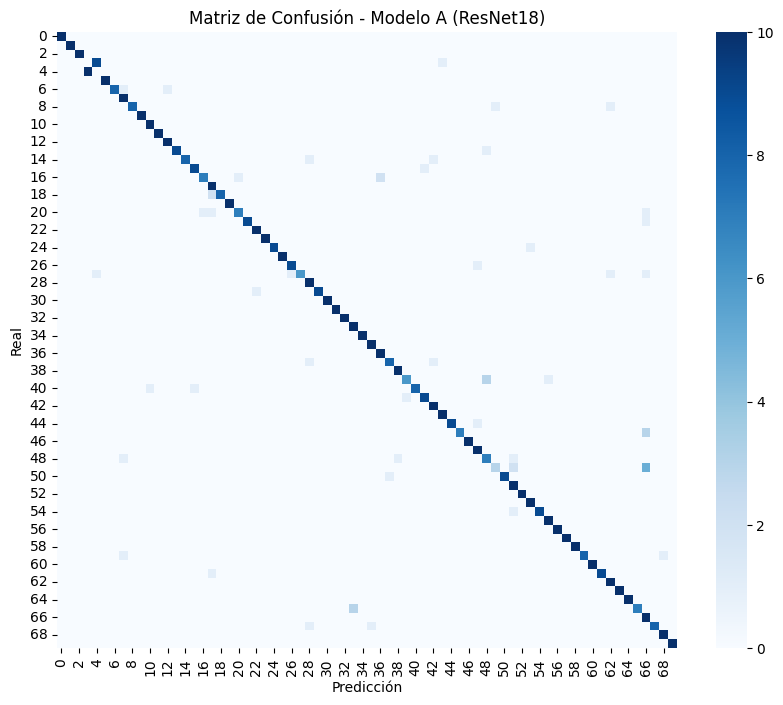

In [40]:
cm_a = confusion_matrix(y_true_a, y_pred_a)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_a, annot=False, cmap="Blues")
plt.title("Matriz de Confusión - Modelo A (ResNet18)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

#### Guardar

In [41]:
torch.save(resnet_model.state_dict(), '/content/resnet18_best.pth')

### Modelo B: CNN Custom

In [33]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(128*28*28, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # [batch, 32, 112, 112]
        x = self.pool(F.relu(self.conv2(x)))   # [batch, 64, 56, 56]
        x = self.pool(F.relu(self.conv3(x)))   # [batch, 128, 28, 28]
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Instanciar modelo
cnn_model = SimpleCNN(num_classes).to(device)

#### Entrenamiento

In [34]:
cnn_criterion = nn.CrossEntropyLoss()
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

cnn_model = train_model(cnn_model, train_loader, val_loader, cnn_criterion, cnn_optimizer, epochs=10)

Epoch 1, Loss: 946.5514, Accuracy: 0.0556
Epoch 2, Loss: 840.5287, Accuracy: 0.1203
Epoch 3, Loss: 752.5464, Accuracy: 0.1983
Epoch 4, Loss: 617.9890, Accuracy: 0.3175
Epoch 5, Loss: 416.3784, Accuracy: 0.5170
Epoch 6, Loss: 222.7166, Accuracy: 0.7267
Epoch 7, Loss: 131.0125, Accuracy: 0.8331
Epoch 8, Loss: 85.5988, Accuracy: 0.8884
Epoch 9, Loss: 68.0080, Accuracy: 0.9106
Epoch 10, Loss: 54.4903, Accuracy: 0.9306
Entrenamiento finalizado.


#### Evaluación

In [35]:
y_true_b, y_pred_b = evaluate_model(cnn_model, val_loader)

                   precision    recall  f1-score   support

           Afghan       0.40      0.20      0.27        10
 African Wild Dog       0.17      0.10      0.12        10
         Airedale       0.00      0.00      0.00        10
American Hairless       0.00      0.00      0.00        10
 American Spaniel       0.00      0.00      0.00        10
          Basenji       0.46      0.60      0.52        10
           Basset       0.12      0.20      0.15        10
           Beagle       0.11      0.10      0.11        10
   Bearded Collie       0.29      0.20      0.24        10
         Bermaise       0.22      0.20      0.21        10
     Bichon Frise       0.38      0.30      0.33        10
         Blenheim       0.18      0.30      0.22        10
       Bloodhound       0.18      0.30      0.22        10
         Bluetick       0.21      0.30      0.25        10
    Border Collie       0.38      0.30      0.33        10
           Borzoi       0.50      0.30      0.38       

#### Matriz de confusión

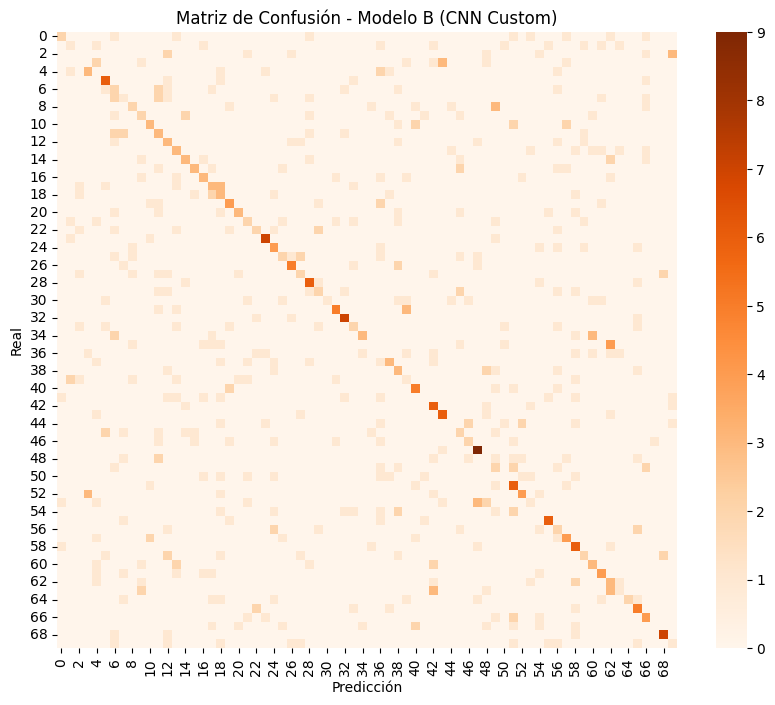

In [42]:
cm_b = confusion_matrix(y_true_b, y_pred_b)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_b, annot=False, cmap="Oranges")
plt.title("Matriz de Confusión - Modelo B (CNN Custom)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

## 2. Integración y Selección en la Aplicación


#### Extraer embbeddings

In [43]:
def extract_embedding_resnet18(model, image_tensor):
    model.eval()
    x = image_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        features = model.conv1(x)
        features = model.bn1(features)
        features = model.relu(features)
        features = model.maxpool(features)
        features = model.layer1(features)
        features = model.layer2(features)
        features = model.layer3(features)
        features = model.layer4(features)
        features = model.avgpool(features)
        embedding = torch.flatten(features, 1)
    return embedding.cpu().numpy().flatten()

def extract_embedding_cnn(model, image_tensor):
    model.eval()
    x = image_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        out = model.pool(F.relu(model.conv1(x)))
        out = model.pool(F.relu(model.conv2(out)))
        out = model.pool(F.relu(model.conv3(out)))
        out = out.view(out.size(0), -1)
        out = model.dropout(F.relu(model.fc1(out)))
    return out.cpu().numpy().flatten()

#### Carga de la base de datos de embeddings

In [44]:
embedding_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Usá el dataset base
all_img_paths = []
all_labels = []
all_embeddings = []

# Recorré todas las carpetas que usaste para la base original
for dataset_folder in [train_dir, valid_dir, test_dir]:
    dataset = datasets.ImageFolder(dataset_folder, transform=transform)
    for i in tqdm(range(len(dataset)), desc=f"Processing {dataset_folder}"):
        img_path, label = dataset.samples[i]
        img = Image.open(img_path).convert('RGB')
        tensor = embedding_transform(img).to(device)
        embedding = extract_embedding_resnet18(resnet_model, tensor)
        all_img_paths.append(img_path)
        all_labels.append(label)
        all_embeddings.append(embedding)


all_embeddings = np.stack(all_embeddings)
all_img_paths = np.array(all_img_paths)
all_labels = np.array(all_labels)

np.save('/content/dog_embeddings_resnet18.npy', all_embeddings)
np.save('/content/dog_img_paths_resnet18.npy', all_img_paths)
np.save('/content/dog_labels_resnet18.npy', all_labels)

dog_embeddings = np.load('/content/dog_embeddings_resnet18.npy')
dog_img_paths = np.load('/content/dog_img_paths_resnet18.npy')
dog_labels = np.load('/content/dog_labels_resnet18.npy')

all_img_paths_cnn = []
all_labels_cnn = []
all_embeddings_cnn = []

for dataset_folder in [train_dir, valid_dir, test_dir]:
    dataset = datasets.ImageFolder(dataset_folder, transform=transform)
    for i in tqdm(range(len(dataset)), desc=f"Processing {dataset_folder}"):
        img_path, label = dataset.samples[i]
        # Open the image and apply the embedding_transform
        img = Image.open(img_path).convert('RGB')
        tensor = embedding_transform(img).to(device)
        embedding = extract_embedding_cnn(cnn_model, tensor)
        all_img_paths_cnn.append(img_path)
        all_labels_cnn.append(label)
        all_embeddings_cnn.append(embedding)


all_embeddings_cnn = np.stack(all_embeddings_cnn)
all_img_paths_cnn = np.array(all_img_paths_cnn)
all_labels_cnn = np.array(all_labels_cnn)

np.save('/content/dog_embeddings_cnn.npy', all_embeddings_cnn)
np.save('/content/dog_img_paths_cnn.npy', all_img_paths_cnn)
np.save('/content/dog_labels_cnn.npy', all_labels_cnn)

Processing /content/dataset/test: 100%|██████████| 1040/1040 [00:03<00:00, 344.07it/s]


#### Función de búsqueda por similitud y voto mayoritario

In [45]:
def buscar_similares(embedding, embeddings_base, top_k=10):
    sims = cosine_similarity(embedding.reshape(1, -1), embeddings_base).flatten()
    idxs = np.argsort(-sims)[:top_k]
    return idxs

def voto_mayoritario(label_ids):
    from collections import Counter
    count = Counter(label_ids)
    most_common_id, _ = count.most_common(1)[0]
    return class_names[int(most_common_id)]  # Aseguramos int

def extract_embedding(model, extractor, img):
    tensor = embedding_transform(img).to(device)
    emb = extractor(model, tensor)
    return emb

#### Función unificada para Gradio: selector y workflow

In [52]:
def gradio_fn(img, modelo):
    try:
        if modelo == "ResNet18 Fine-tuned":
            model, extractor = resnet_model, extract_embedding_resnet18
            embeddings = np.load('/content/dog_embeddings_resnet18.npy')
            img_paths = np.load('/content/dog_img_paths_resnet18.npy')
            labels = np.load('/content/dog_labels_resnet18.npy')
        else:
            model, extractor = cnn_model, extract_embedding_cnn
            embeddings = np.load('/content/dog_embeddings_cnn.npy')
            img_paths = np.load('/content/dog_img_paths_cnn.npy')
            labels = np.load('/content/dog_labels_cnn.npy')
        emb = extract_embedding(model, extractor, img).reshape(1, -1)
        idxs = buscar_similares(emb, embeddings)
        imgs_similares = [Image.open(img_paths[i]) for i in idxs]
        labels_similares = [labels[i] for i in idxs]
        pred_raza = voto_mayoritario(labels_similares)
        return pred_raza, [img] + imgs_similares
    except Exception as e:
        import traceback
        traceback.print_exc()
        return f"Error: {str(e)}", []

#### Lanzar Gradio con selector de modelo

In [53]:
gr.Interface(
    fn=gradio_fn,
    inputs=[
        gr.Image(type="pil", label="Sube una imagen de perro"),
        gr.Dropdown(choices=["ResNet18 Fine-tuned", "CNN Custom"], label="Modelo a usar")
    ],
    outputs=[
        gr.Text(label="Raza Predicha (voto mayoritario)"),
        gr.Gallery(label="Imágenes más similares (incluye la de entrada)")
    ],
    title="Sistema de Clasificación de Razas de Perros (Etapa 2)"
).launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3f9e06a7343da7f22b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Etapa 3: Pipeline de Detección y Clasificación en Escenas Complejas

### Instalación de dependencias

In [129]:
!pip install ultralytics
!pip install torch torchvision  # Por si falta PyTorch
!pip install opencv-python
!pip install gradio

### Imports

In [130]:
import torch
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image, ImageDraw, ImageFont
from ultralytics import YOLO

### Generar archivo de clases

In [131]:
csv_path = '/content/dataset/dogs.csv'

df = pd.read_csv(csv_path)
# Excluir la clase 'American Spaniel'
class_names = sorted([label for label in df['labels'].unique() if label != 'American  Spaniel'])  # Esto te da todas las razas

print(f"Se encontraron {len(class_names)} razas. Ejemplo:", class_names[:5])

with open('class_names.txt', 'w') as f:
    for c in class_names:
        f.write(f"{c}\n")

print("Archivo class_names.txt generado correctamente.")

Se encontraron 70 razas. Ejemplo: ['Afghan', 'African Wild Dog', 'Airedale', 'American Hairless', 'American Spaniel']
Archivo class_names.txt generado correctamente.


### Cargar modelos y clases

In [132]:
ruta_pesos = '/content/resnet18_best.pth'
ruta_clases = '/content/class_names.txt'

# Leer clases, con filtro de líneas vacías
with open(ruta_clases, 'r') as f:
    class_names = [line.strip() for line in f.readlines() if line.strip() != '']

# Construir modelo
model = torchvision.models.resnet18()
model.fc = torch.nn.Linear(model.fc.in_features, len(class_names))  # = 70
model.load_state_dict(torch.load(ruta_pesos, map_location='cpu'))   # O 'cuda'
model = model.to(device)
model.eval()

print(f"{len(class_names)} razas cargadas.")

70 razas cargadas.


### Cargar modelo YOLOv8

In [133]:
# Usar tu archivo local
yolo_model = YOLO('/content/yolov8n.pt')

### Funciones pipeline

In [134]:
def detectar_perros_yolo(imagen_bgr):
    resultados = yolo_model.predict(imagen_bgr)
    boxes = []
    for r in resultados:
        for box in r.boxes:
            cls = int(box.cls[0].item())
            # Clase 16 es 'dog' en COCO
            if cls == 16:
                x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
                boxes.append((x1, y1, x2, y2))
    return boxes

def recortar_perros(imagen_bgr, boxes):
    recortes = []
    for (x1, y1, x2, y2) in boxes:
        crop = imagen_bgr[y1:y2, x1:x2]
        if crop.shape[0] > 0 and crop.shape[1] > 0:
            recortes.append(crop)
    return recortes

def predecir_raza_perro(crop_img, model, class_names):
    try:
        input_tensor = transform(crop_img).unsqueeze(0).to(device)
    except Exception as e:
        print("Error en transform:", e)
        return "Desconocido"
    with torch.no_grad():
        output = model(input_tensor)
        pred_idx = torch.argmax(output, dim=1).item()
    return class_names[pred_idx]

def dibujar_bboxes_y_etiquetas(imagen_bgr, boxes, etiquetas):
    img_pil = Image.fromarray(cv2.cvtColor(imagen_bgr, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(img_pil)
    try:
        font = ImageFont.truetype("arial.ttf", 18)
    except:
        font = ImageFont.load_default()
    for (box, etiqueta) in zip(boxes, etiquetas):
        x1, y1, x2, y2 = box
        draw.rectangle([x1, y1, x2, y2], outline='red', width=3)
        draw.text((x1, max(y1 - 20, 0)), etiqueta, fill='red', font=font)
    return np.array(img_pil)

### Probar con una imagen suelta

### Interfaz Gradio

In [136]:
def gradio_fn(imagen):
    imagen_bgr = cv2.cvtColor(imagen, cv2.COLOR_RGB2BGR)
    boxes = detectar_perros_yolo(imagen_bgr)
    recortes = recortar_perros(imagen_bgr, boxes)
    etiquetas = []
    for crop in recortes:
        etiqueta = predecir_raza_perro(crop, model, class_names)
        etiquetas.append(etiqueta)
    imagen_con_bboxes = dibujar_bboxes_y_etiquetas(imagen_bgr, boxes, etiquetas)
    return cv2.cvtColor(imagen_con_bboxes, cv2.COLOR_BGR2RGB)

gr.Interface(
    fn=gradio_fn,
    inputs=gr.Image(type="numpy"),
    outputs=gr.Image(type="numpy"),
    title="Detector y Clasificador de Razas de Perros"
).launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0b8b6988d1ddaf330f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Etapa 4: Evaluación, Optimización y Herramientas de Anotación


### Instalaciones

In [92]:
!pip install ultralytics --quiet
!pip install fiftyone --quiet  # para visualización y evaluación
!pip install opencv-python-headless --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.3/306.3 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 943.0/943.0 kB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 15.7 MB/s eta 0

### Imports

In [100]:
import torch
import torchvision.transforms as T
from ultralytics import YOLO
import cv2
import os
import random
import json
import shutil
import numpy as np
import requests
from collections import Counter
from io import BytesIO
from PIL import Image
from tqdm import tqdm
import torchvision
import torchvision.models as models
import numpy as np
from glob import glob
import time

In [101]:
# Si usás CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Carpeta temporal de trabajo
WORKDIR = 'tp_final_etapa4'
os.makedirs(WORKDIR, exist_ok=True)

### 1. Evaluación del Pipeline

#### Generación de imágenes sintéticas

In [118]:
DATASET_DIR = "/content/dataset/train"
OUTPUT_DIR = "/content/imagenes_complejas"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Fondos públicos
fondos_urls = [
    "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/graf1.png",
    "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/fruits.jpg",
    "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/lena.jpg",
    "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/sudoku.png",
    "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/blox.jpg",
    "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/baboon.jpg",
    "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/chessboard.png",
    "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/opencv-logo-white.png",
    "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/smarties.png",
    "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/fruits.jpg"
]
FONDOS = []
for url in fondos_urls:
    response = requests.get(url)
    fondo = Image.open(BytesIO(response.content)).resize((512, 512)).convert("RGB")
    FONDOS.append(np.array(fondo))

# Obtener lista de imágenes de perros y sus clases (subcarpeta=raza)
dog_images = []
clases = []
for dp, dn, filenames in os.walk(DATASET_DIR):
    for f in filenames:
        if f.endswith(".jpg"):
            dog_images.append(os.path.join(dp, f))
            clases.append(os.path.basename(os.path.dirname(os.path.join(dp, f))))
random.seed(42)
indices = random.sample(range(len(dog_images)), 10)
dog_images_sel = [dog_images[i] for i in indices]
dog_clases_sel = [clases[i] for i in indices]

# Diccionario para ground truth
ground_truth = {}

def combinar_perro_y_fondo(perro_path, fondo_img, salida_path):
    perro = Image.open(perro_path).convert("RGBA").resize((224, 224))
    fondo = Image.fromarray(fondo_img).resize((512, 512)).convert("RGBA")
    pos = (random.randint(0, 288), random.randint(0, 288))
    fondo.paste(perro, pos, perro)
    fondo.convert("RGB").save(salida_path)
    # Guardamos bounding box y clase
    bbox = [pos[0], pos[1], 224, 224]
    return bbox

for i, (perro_path, raza) in enumerate(zip(dog_images_sel, dog_clases_sel)):
    salida = os.path.join(OUTPUT_DIR, f"compleja_{i}.jpg")
    bbox = combinar_perro_y_fondo(perro_path, FONDOS[i], salida)
    ground_truth[f"compleja_{i}.jpg"] = {
        "bbox": bbox,
        "class": raza
    }

# Guardar ground truth en JSON
with open(os.path.join(OUTPUT_DIR, "ground_truth.json"), "w") as f:
    json.dump(ground_truth, f, indent=2)

#### Cálculo de métricas (IoU, mAP, Precision, Recall, F1)

In [119]:
def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0]+boxA[2], boxB[0]+boxB[2])
    yB = min(boxA[1]+boxA[3], boxB[1]+boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

TP, FP, FN = 0, 0, 0
ious, precisiones, recalls, f1s = [], [], [], []
iou_threshold = 0.5

for fname, gt in ground_truth.items():
    gt_bbox = gt["bbox"]
    gt_class = gt["class"]
    preds = predicciones.get(fname, [])
    best_iou = 0
    best_pred = None
    for pred in preds:
        pred_bbox = pred["bbox"]
        pred_class = pred["class"]
        curr_iou = iou(gt_bbox, pred_bbox)
        if curr_iou > best_iou:
            best_iou = curr_iou
            best_pred = pred
    # Evaluación
    if best_pred and best_iou >= iou_threshold:
        ious.append(best_iou)
        if best_pred["class"] == gt_class:
            TP += 1
        else:
            FP += 1
    else:
        FN += 1

# Cálculo de métricas globales
precision = TP / (TP + FP + 1e-6)
recall = TP / (TP + FN + 1e-6)
f1 = 2 * precision * recall / (precision + recall + 1e-6)
mean_iou = np.mean(ious) if ious else 0.0

print(f"IoU promedio: {mean_iou:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"True Positives: {TP}, False Positives: {FP}, False Negatives: {FN}")

# mAP (muy simplificado para 1 instancia por imagen)
mAP = precision
print(f"mAP (aprox): {mAP:.3f}")

IoU promedio: 0.919
Precision: 0.333
Recall: 0.750
F1-score: 0.462
True Positives: 3, False Positives: 6, False Negatives: 1
mAP (aprox): 0.333


#### Visualizar algunos resultados


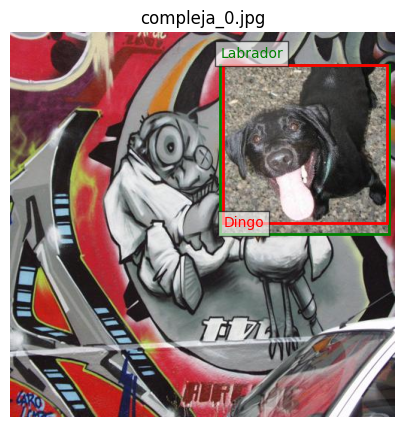

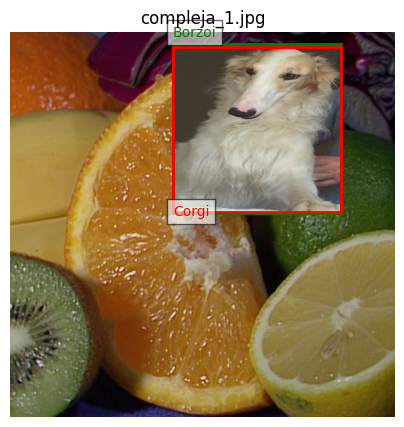

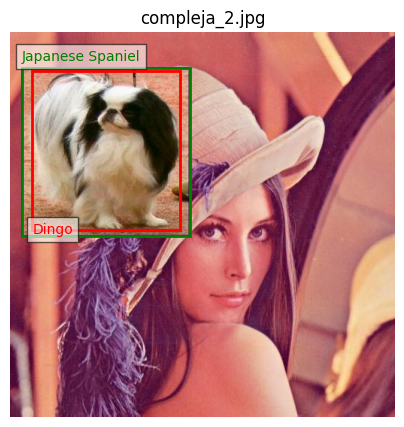

In [120]:
for idx, (fname, gt) in enumerate(ground_truth.items()):
    img = Image.open(os.path.join(OUTPUT_DIR, fname)).convert("RGB")
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    # Ground truth en verde
    x, y, w, h = gt["bbox"]
    plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor='g', facecolor='none', lw=2, label='GT'))
    plt.text(x, y-10, gt["class"], color='g', fontsize=10, bbox=dict(facecolor='white', alpha=0.6))
    # Predicción en rojo (primera, si hay)
    preds = predicciones.get(fname, [])
    if preds:
        px, py, pw, ph = preds[0]["bbox"]
        plt.gca().add_patch(plt.Rectangle((px, py), pw, ph, edgecolor='r', facecolor='none', lw=2, label='Pred'))
        plt.text(px, py+ph+5, preds[0]["class"], color='r', fontsize=10, bbox=dict(facecolor='white', alpha=0.6))
    plt.title(fname)
    plt.axis('off')
    plt.show()
    if idx >= 2:  # solo muestra 3 ejemplos
        break

### 2. Optimización del modelos

#### Cuantización dinámica de tu modelo de clasificación

In [122]:
# Cargar modelo original
modelo = models.resnet18(num_classes=70)
modelo.load_state_dict(torch.load("resnet18_best.pth", map_location=torch.device('cpu')))
modelo.eval()

# Cuantizar dinámicamente
modelo_quant = torch.quantization.quantize_dynamic(modelo, {torch.nn.Linear}, dtype=torch.qint8)

# Obtener clases del test set
test_dir = "/content/dataset/test"
clases = sorted([d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))])
clase2idx = {c: i for i, c in enumerate(clases)}

# Elegir hasta 100 imágenes (una por clase si hay, o random)
test_images = []
test_labels = []
for clase in clases:
    clase_dir = os.path.join(test_dir, clase)
    archivos = [f for f in os.listdir(clase_dir) if f.endswith('.jpg')]
    for f in archivos[:1]:  # puedes poner más imágenes por clase si quieres
        test_images.append(os.path.join(clase_dir, f))
        test_labels.append(clase2idx[clase])
    if len(test_images) >= 100:
        break

# Función para medir velocidad y precisión
def medir_velocidad_y_accuracy(model, images, labels):
    correct = 0
    total = 0
    start = time.time()
    with torch.no_grad():
        for img_path, label in zip(images, labels):
            img = Image.open(img_path).convert("RGB")
            x = transform(img).unsqueeze(0)
            outputs = model(x)
            pred = outputs.argmax(1).item()
            if pred == label:
                correct += 1
            total += 1
    elapsed = time.time() - start
    accuracy = correct / total if total > 0 else 0
    return elapsed, accuracy

# Medición
t_normal, acc_normal = medir_velocidad_y_accuracy(modelo, test_images, test_labels)
t_quant, acc_quant = medir_velocidad_y_accuracy(modelo_quant, test_images, test_labels)

print(f"Velocidad original: {t_normal:.3f}s | Precisión: {acc_normal*100:.2f}%")
print(f"Velocidad cuantizado: {t_quant:.3f}s | Precisión: {acc_quant*100:.2f}%")

# (Opcional) Comparar tamaño de los archivos de pesos
torch.save(modelo.state_dict(), "modelo_fp32.pth")
torch.save(modelo_quant.state_dict(), "modelo_int8.pth")
import os
print(f"Modelo FP32: {os.path.getsize('modelo_fp32.pth')/1024/1024:.2f} MB")
print(f"Modelo INT8: {os.path.getsize('modelo_int8.pth')/1024/1024:.2f} MB")


Velocidad original: 5.700s | Precisión: 91.43%
Velocidad cuantizado: 4.825s | Precisión: 91.43%
Modelo FP32: 42.85 MB
Modelo INT8: 42.74 MB


### 3. Script de Anotación Automática

#### Exportación automática de anotaciones (YOLOv5 y COCO)

In [123]:
# Obtener las clases desde el modelo de test
test_dir = "/content/dataset/test"
clases = sorted([d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))])
clase2idx = {c: i for i, c in enumerate(clases)}
idx2clase = {i: c for c, i in clase2idx.items()}

# Carpeta de anotaciones YOLO
YOLO_DIR = os.path.join(OUTPUT_DIR, "anotaciones_yolo")
os.makedirs(YOLO_DIR, exist_ok=True)

# Anotaciones para COCO
COCO_OUT = {
    "images": [],
    "annotations": [],
    "categories": [{"id": i, "name": c} for i, c in enumerate(clases)]
}
ann_id = 0

for img_id, fname in enumerate(sorted(os.listdir(OUTPUT_DIR))):
    if not fname.endswith(".jpg"):
        continue
    fpath = os.path.join(OUTPUT_DIR, fname)
    image = cv2.imread(fpath)
    height, width = image.shape[:2]

    # Detectar perros con YOLO
    detections = yolo(fpath)[0]
    bboxes = []
    yolo_lines = []

    for det in detections.boxes:
        x1, y1, x2, y2 = map(int, det.xyxy[0])
        # Recorte para clasificar
        crop = image[y1:y2, x1:x2]
        if crop.size == 0:
            continue
        crop_pil = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)).convert("RGB")
        input_tensor = transform(crop_pil).unsqueeze(0)
        with torch.no_grad():
            out = modelo(input_tensor)
            class_idx = out.argmax(1).item()
        # YOLOv5 formato normalizado
        cx, cy = (x1+x2)/2/width, (y1+y2)/2/height
        w, h = (x2-x1)/width, (y2-y1)/height
        yolo_lines.append(f"{class_idx} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}")
        # COCO formato absoluto
        COCO_OUT["annotations"].append({
            "id": ann_id,
            "image_id": img_id,
            "category_id": class_idx,
            "bbox": [x1, y1, x2-x1, y2-y1],
            "area": (x2-x1)*(y2-y1),
            "iscrowd": 0
        })
        ann_id += 1

    # Guardar .txt de YOLOv5
    with open(os.path.join(YOLO_DIR, fname.replace(".jpg",".txt")), "w") as f:
        for line in yolo_lines:
            f.write(line+"\n")

    # Agregar imagen a COCO
    COCO_OUT["images"].append({"id": img_id, "file_name": fname, "height": height, "width": width})

# Guardar anotaciones COCO
with open(os.path.join(OUTPUT_DIR, "anotaciones_coco.json"), "w") as f:
    json.dump(COCO_OUT, f, indent=2)

print(f"Anotaciones YOLOv5 en: {YOLO_DIR}")
print(f"Anotaciones COCO en: {os.path.join(OUTPUT_DIR, 'anotaciones_coco.json')}")


image 1/1 /content/imagenes_complejas/compleja_0.jpg: 640x640 2 dogs, 13.0ms
Speed: 4.9ms preprocess, 13.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/imagenes_complejas/compleja_1.jpg: 640x640 1 dog, 2 oranges, 11.8ms
Speed: 2.8ms preprocess, 11.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/imagenes_complejas/compleja_2.jpg: 640x640 1 person, 1 dog, 1 bed, 11.7ms
Speed: 4.2ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/imagenes_complejas/compleja_3.jpg: 640x640 (no detections), 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/imagenes_complejas/compleja_4.jpg: 640x640 1 dog, 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/imagenes_complejas/compleja_5.jpg: 640x640 1 person, 1 dog, 7.8ms
Speed: 2.